In [3]:
import csv
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import *
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import datetime
from textblob import TextBlob
import matplotlib.pyplot as plt
from langdetect import detect


from nltk.corpus import stopwords

In [131]:
df = pd.read_csv('tweets.csv',dtype=object, sep = ';')

In [132]:
df['timestamp'] =  pd.to_datetime(df['timestamp'],errors='coerce')

In [133]:
df.shape

(20165013, 9)

In [134]:
mask = (df['timestamp'].dt.date > datetime(2018, 11, 23).date()) & (df['timestamp'].dt.date <= datetime(2019, 3, 29).date())
df = df.loc[mask]

In [135]:
df.shape

(584391, 9)

In [136]:
# grouped = df4.groupby(df['timestamp'].dt.date)

In [137]:
# dates = []

# for name, group in grouped:
#     dates.append(name)


In [138]:
def single_preprocessing(document):
    """
    This function performs for a single text all preprocessing steps
    parameter: text as string
    output: list of that contains the preprocessed tokens
    """
        
    # preprosessing of the stopwords:
    lemmatizer = WordNetLemmatizer()
    
    stop_words = list(set(stopwords.words('english')))
    
    preprocessed_stop_words = []
    
    for k in np.arange(len(stop_words)):
        text= ""
        for i in np.arange(len(stop_words[k])):
            if stop_words[k][i].isalpha() or stop_words[k][i].isspace():
                text += stop_words[k][i].lower()
        text = lemmatizer.lemmatize(text)
        preprocessed_stop_words.append(text)
    
    # preprosessing of the actual text
    
    # list containing the regexes to clean the texts for not wanted pattern
    regex_list = ['https:(\S){1,}','www.(\S){1,}']
    
    # list to save the preprocessed text
    preprocessed_document = []

    # use the regex list to remove unwanted pattern
    for i in np.arange(len(regex_list)):
        document = re.sub(regex_list[i], '', document, count=0, flags=0)

    # remove non-alphabetical chars except space and split the text into a list of tokens
    text= ""
    for i in np.arange(len(document)):
        if document[i].isalpha() or document[i].isspace():
            text += document[i].lower()
    text_split = text.split()

    # lemmatize each token and remove it if it is part of the stopwords
    #print("Before:",len(text_split))
    for i in text_split:
        if i not in preprocessed_stop_words:
            preprocessed_document.append(i)
            
#     print("After:",len(preprocessed_document))
    
    
    return ' '.join(preprocessed_document)

In [139]:
def nested_preprocessing(corpus):
    """
    This function performs for a list of texts all preprocessing steps
    parameter: list of texts
    output: list of lists containing where each contained lists contains the preprocessed tokens
    """
    
    preprocessed_corpus = [single_preprocessing(k) for k in corpus]

    return preprocessed_corpus

In [140]:
df.dropna(subset=['text'], inplace=True)

In [141]:
df['preprocessed_text'] = df4['text'].apply(single_preprocessing)

In [142]:
df.shape

(584062, 10)

In [143]:
lang = detect(df['preprocessed_text'].iloc[0])
print(lang)

en


In [ ]:
language = []

for key, value in enumerate(df['preprocessed_text']):
    try:
        lang = detect(value)
        language.append(lang)
    except:
        print("No features in text")
        language.append('no_language')

No features in text
No features in text
No features in text
No features in text
No features in text
No features in text
No features in text
No features in text
No features in text
No features in text
No features in text
No features in text
No features in text


In [ ]:
df['language'] = language

In [ ]:
df['language'].value_counts()

In [ ]:
df = df[df['language'] == 'en']

In [113]:
df.to_csv('processed_tweets.csv', index=False)

In [4]:
df = pd.read_csv('processed_tweets.csv',dtype=object, sep = ',')

In [5]:
df.shape

(421142, 11)

In [6]:
df['timestamp'] =  pd.to_datetime(df['timestamp'],errors='coerce')

In [27]:
grouped = df6.groupby(df6['timestamp'].dt.date)

In [28]:
dates = []

for name, group in grouped:
    dates.append(name)


In [7]:
df['likes'] = df['likes'].astype(int)
df['retweets'] = df['retweets'].astype(int)

In [8]:
# mask = (df['likes'] > 5) | (df['retweets'] > 5)

In [9]:
# df = df.loc[mask]

In [10]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [11]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",num_labels=3)
nlp = pipeline("sentiment-analysis",model=model,tokenizer=tokenizer)

In [12]:
analyzer = SentimentIntensityAnalyzer()

In [13]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
 
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def analyze_sentiment_pos(tweet):
    sentiment_dict = analyzer.polarity_scores(tweet)
    return str(sentiment_dict['pos'])

def analyze_sentiment_Neg(tweet):
    sentiment_dict = analyzer.polarity_scores(tweet)
    return sentiment_dict['neg']

def analyze_sentiment_Neu(tweet):
    sentiment_dict = analyzer.polarity_scores(tweet)
    return sentiment_dict['neu']

def analyze_sentiment_Comp(tweet):
    sentiment_dict = analyzer.polarity_scores(tweet)
    return sentiment_dict['compound']

def analyze_sentiment_BERT_int(tweet):
#     print(len(tweet))
    sentiment_dict = nlp(tweet)
    return sentiment_dict[0]['score']

def analyze_sentiment_BERT(tweet):
    sentiment_dict = nlp(tweet)
    if sentiment_dict[0]['label']=='positive':
      return 2
    elif sentiment_dict[0]['label']=='neutral':
      return 1
    else: return -1

In [14]:
df["Vader_Comp"] = df['preprocessed_text'].apply(analyze_sentiment_Comp)
df["Vader_Pos"] = df['preprocessed_text'].apply(analyze_sentiment_pos)
df["Vader_Neg"] = df['preprocessed_text'].apply(analyze_sentiment_Neg)
df["Vader_Neu"] = df['preprocessed_text'].apply(analyze_sentiment_Neu)

In [15]:
df["BERT_SCORE"] = df['preprocessed_text'].apply(analyze_sentiment_BERT_int)

# df7["BERT_LABEL"] = df7['text'].apply(analyze_sentiment_BERT)

In [16]:
df.to_csv('bert_tweets.csv', index=False)

In [17]:
df["BERT_Sentiment"] = df['preprocessed_text'].apply(analyze_sentiment_BERT)


In [18]:
df.to_csv('bert_tweets.csv', index=False)

In [19]:
df7 = pd.read_csv('bert_tweets.csv')

In [24]:
df7.head(20)

,id,user,fullname,url,timestamp,replies,likes,retweets,text,preprocessed_text,language,Vader_Comp,Vader_Pos,Vader_Neg,Vader_Neu,BERT_SCORE,BERT_Sentiment
0,1105610249069883392,coinairdropall,Crypto Airdrops,NaN,2019-03-12 23:23:19+00:00,1,0,1,#Bitcoin #Satoshi #crypto #blockchain #Airdrop...,bitcoin satoshi crypto blockchain airdrop new ...,en,0.2263,0.091,0.000,0.909,0.895744,1
1,1108810883290095616,Airdropnotecom,Crypto Airdrops,NaN,2019-03-21 19:21:29+00:00,0,13,13,#Bitcoin #Satoshi #crypto #blockchain #Airdrop...,bitcoin satoshi crypto blockchain airdrop new ...,en,0.9260,0.420,0.000,0.580,0.883305,1
2,1104519969398816771,coinairdropall,Crypto Airdrops,NaN,2019-03-09 23:10:56+00:00,0,0,1,#Bitcoin #Satoshi #crypto #blockchain #Airdrop...,bitcoin satoshi crypto blockchain airdrop new ...,en,0.0000,0.000,0.000,1.000,0.900940,1
3,1105606801914060801,CoinsAirdrops,Crypto Airdrops,NaN,2019-03-12 23:09:37+00:00,1,13,9,#Bitcoin #crypto #Airdrop\nNew Airdrop #p2pb2b...,bitcoin crypto airdrop new airdrop ppbb airdro...,en,0.5859,0.202,0.000,0.798,0.921648,1
4,1078873154376880129,TheBitfi,Bitfi - open source: bitfi.dev,NaN,2018-12-29 04:39:39+00:00,9,61,16,The first lab made diamond happened in 1955 &a...,first lab made diamond happened amp flawless m...,en,0.6908,0.180,0.000,0.820,0.872292,1
5,1105611129773006848,coinairdropall,Crypto Airdrops,NaN,2019-03-12 23:26:49+00:00,0,0,1,#Bitcoin #crypto #Airdrop\nNew Airdrop #Crypto...,bitcoin crypto airdrop new airdrop cryptosoul ...,en,-0.3818,0.000,0.094,0.906,0.830180,1
6,1108499115334348801,Airdropnotecom,Crypto Airdrops,NaN,2019-03-20 22:42:38+00:00,2,8,8,#Bitcoin #Satoshi #crypto\nCrypto Wallet #XAPO...,bitcoin satoshi crypto crypto wallet xapo xapo...,en,0.6249,0.203,0.000,0.797,0.931054,1
7,1105611397872996354,coinairdropall,Crypto Airdrops,NaN,2019-03-12 23:27:53+00:00,0,0,1,#Bitcoin #crypto #Airdrop\nNew Airdrop #Bitdep...,bitcoin crypto airdrop new airdrop bitdeposita...,en,0.7783,0.238,0.000,0.762,0.923276,1
8,1105611682410315777,coinairdropall,Crypto Airdrops,NaN,2019-03-12 23:29:01+00:00,0,0,1,#Bitcoin #crypto #Airdrop\nNew Airdrop #p2pb2b...,bitcoin crypto airdrop new airdrop ppbb airdro...,en,0.5859,0.202,0.000,0.798,0.921648,1
9,1100771310249095170,Airdropnotecom,Crypto Airdrops,NaN,2019-02-27 14:55:06+00:00,6,21,11,#Bitcoin #crypto #Airdrop\nNew Airdrop #BIGtok...,bitcoin crypto airdrop new airdrop bigtoken ea...,en,0.8126,0.344,0.000,0.656,0.632297,2


In [81]:
tweets_data = {'date': [], 'tweets_number': [], 'replies': [], 'likes': [], 'retweets':[], 'BERT_SCORE':[], 'Vader_Comp':[]}

tdf = pd.DataFrame(tweets_data)

In [82]:
def dt(x):
    t = pd.Timestamp(x)
    return pd.Timestamp.date(t)

df7.timestamp = df7.timestamp.apply(dt)

In [83]:
df7['timestamp'].loc[0]

datetime.date(2018, 12, 29)

In [68]:
sdf=pd.DataFrame(df7['timestamp'].value_counts())
sdf = sdf.reset_index()
sdf.columns = ['date','tweets_number']
sdf = sdf.sort_values(by=['date'], ascending=True)
sdf.insert(0, 'id_d', range(1, 1 + len(sdf)))
sdf = sdf.reset_index()
sdf = sdf[['date','tweets_number']]
sdf

,date,tweets_number
0,2016-01-02,2
1,2016-01-04,1
2,2016-01-07,2
3,2016-01-08,1
4,2016-01-11,2
...,...,...
1096,2019-03-25,64
1097,2019-03-26,85
1098,2019-03-27,75
1099,2019-03-28,234


for date in sdf['date']:
    sdf.loc[sdf['date'] == date, 'likes_sum'] = df7.loc[df7['timestamp'] == date, 'likes'].sum()

for date in sdf['date']:
    sdf.loc[sdf['date'] == date, 'replies_sum'] = df7.loc[df7['timestamp'] == date, 'replies'].sum()
    sdf.loc[sdf['date'] == date, 'retweets_sum'] = df7.loc[df7['timestamp'] == date, 'retweets'].sum()

for date in sdf['date']:
    sdf.loc[sdf['date'] == date, 'BERT_SCORE_sum'] = df7.loc[df7['timestamp'] == date, 'BERT_SCORE'].sum()
    sdf.loc[sdf['date'] == date, 'Vader_Comp_sum'] = df7.loc[df7['timestamp'] == date, 'Vader_Comp'].sum()

In [29]:
for date in sdf['date']:
    sdf.loc[sdf['date'] == date, 'likes_mean'] = df7.loc[df7['timestamp'] == date, 'likes'].mean()
    
for date in sdf['date']:
    sdf.loc[sdf['date'] == date, 'replies_mean'] = df7.loc[df7['timestamp'] == date, 'replies'].mean()
    sdf.loc[sdf['date'] == date, 'retweets_mean'] = df7.loc[df7['timestamp'] == date, 'retweets'].mean()
    
for date in sdf['date']:
    sdf.loc[sdf['date'] == date, 'BERT_SCORE_mean'] = df7.loc[df7['timestamp'] == date, 'BERT_SCORE'].mean()
    sdf.loc[sdf['date'] == date, 'Vader_Comp_mean'] = df7.loc[df7['timestamp'] == date, 'Vader_Comp'].mean()

In [30]:
sdf['date'] =  pd.to_datetime(sdf['date'],errors='coerce')

In [31]:
# Find the range of dates in the dataframe
date_range = pd.date_range(start=sdf['date'].min(), end=sdf['date'].max(), freq='D')

# Reindex the dataframe to align with the range of dates
sdf = sdf.set_index('date').reindex(date_range, fill_value=0)
sdf.reset_index(inplace=True)
sdf.rename(columns={'index': 'date'}, inplace=True)
sdf.shape

(1183, 8)

In [12]:
btc = pd.read_csv('BTC-EUR2019.csv')

In [13]:
btc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-02,400.278137,401.604370,397.743591,399.187683,399.187683,27718364
1,2016-01-03,399.316650,399.468597,391.145691,396.360016,396.360016,36532215
2,2016-01-04,396.406128,401.623993,395.797455,400.194977,400.194977,35554888
3,2016-01-05,400.174652,401.314362,399.884583,401.898010,401.898010,32120022
4,2016-01-06,401.801239,401.801239,396.743896,398.278259,398.278259,31596900


In [14]:
sdf.shape

(1183, 8)

In [15]:
sdf['BTC'] = btc['Close'].copy()

In [16]:
sdf

,date,id_d,tweets_number,likes_mean,replies_mean,retweets_mean,BERT_SCORE_mean,Vader_Comp_mean,BTC
0,2016-01-02,1,2,26.000000,0.500000,35.000000,0.838269,0.598400,399.187683
1,2016-01-03,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,396.360016
2,2016-01-04,2,1,25.000000,1.000000,23.000000,0.715233,-0.440400,400.194977
3,2016-01-05,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,401.898010
4,2016-01-06,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,398.278259
...,...,...,...,...,...,...,...,...,...
1178,2019-03-25,1097,64,109.765625,17.296875,37.296875,0.877080,0.324702,3502.470703
1179,2019-03-26,1098,85,164.600000,20.458824,72.223529,0.884376,0.345486,3534.563477
1180,2019-03-27,1099,75,129.026667,9.386667,46.266667,0.877857,0.169812,3631.979492
1181,2019-03-28,1100,234,106.380342,8.940171,28.303419,0.859504,0.204927,3623.731201


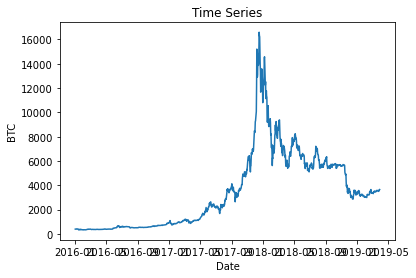

In [17]:

sdf.set_index('date', inplace=True)

# Select the column of interest
column = sdf['BTC']

# Plot the time series
plt.plot(column)
plt.xlabel('Date')
plt.ylabel('BTC')
plt.title('Time Series')
plt.show()


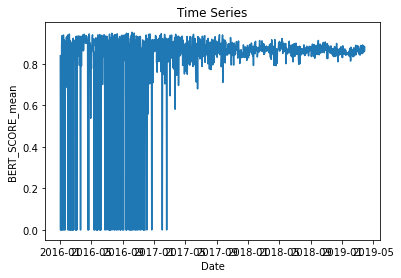

In [18]:
# Select the column of interest
column = sdf['BERT_SCORE_mean']

# Plot the time series
plt.plot(column)
plt.xlabel('Date')
plt.ylabel('BERT_SCORE_mean')
plt.title('Time Series')
plt.show()

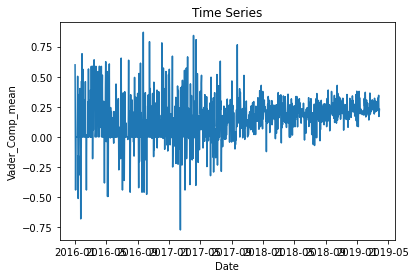

In [19]:
# Select the column of interest
column = sdf['Vader_Comp_mean']

# Plot the time series
plt.plot(column)
plt.xlabel('Date')
plt.ylabel('Vader_Comp_mean')
plt.title('Time Series')
plt.show()

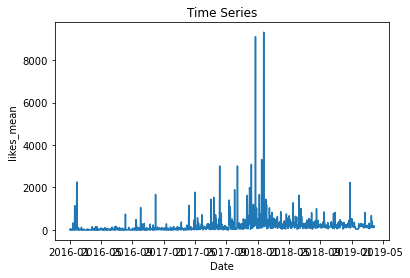

In [20]:
# Select the column of interest
column = sdf['likes_mean']

# Plot the time series
plt.plot(column)
plt.xlabel('Date')
plt.ylabel('likes_mean')
plt.title('Time Series')
plt.show()

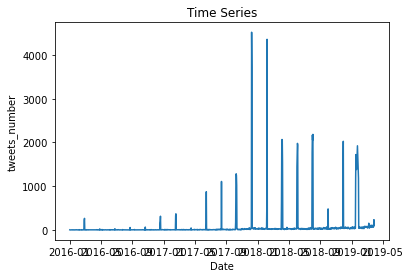

In [21]:
# Select the column of interest
column = sdf['tweets_number']

# Plot the time series
plt.plot(column)
plt.xlabel('Date')
plt.ylabel('tweets_number')
plt.title('Time Series')
plt.show()

In [22]:
sdf['tweets_number'].mean()

73.22823330515638

In [23]:
# sdf= sdf[sdf.index > datetime(2018, 11, 23).date()]
sdf = sdf.loc['2018-11-23':]

In [242]:
sdf.shape

(127, 8)

In [244]:
sdf.to_csv("final_data.csv", index=True)

In [243]:
sdf.head()

,id_d,tweets_number,likes_mean,replies_mean,retweets_mean,BERT_SCORE_mean,Vader_Comp_mean,BTC
date,,,,,,,,
2018-11-23,975,39,234.666667,17.948718,69.897436,0.872507,0.352369,3833.607666
2018-11-24,976,38,280.157895,20.026316,72.736842,0.869439,0.149608,3422.345215
2018-11-25,977,61,328.573770,18.459016,85.704918,0.839590,0.214480,3537.531494
2018-11-26,978,62,268.080645,15.467742,66.403226,0.855086,0.198289,3334.840332
2018-11-27,979,45,258.311111,21.977778,88.666667,0.852590,0.079982,3381.917969
